# 1) Data preprocessing

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


In [2]:
# Load JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    print(f"Loaded {len(data)} records from {file_path}.")
    return data

In [3]:
# Extract features from the training dataset
def extract_training_data(training_data):
    post_data = []
    profile_data = []

    for item in training_data:
        # Extract profile-level data
        profile = item.get('profile', {})
        profile_id = profile.get('id', 'UNKNOWN')
        username = profile.get('username', 'UNKNOWN')
        post_count = profile.get('post_count', 0)
        follower_count = profile.get('follower_count', 0)
        highlight_reel_count = profile.get('highlight_reel_count', 0)
        
        # Save profile-level data
        profile_data.append({
            'profile_id': profile_id,
            'username': username,
            'post_count': post_count,
            'follower_count': follower_count,
            'highlight_reel_count': highlight_reel_count
        })
        
        # Extract post-level data
        for post in item.get('posts', []):
            post_id = post.get('id', 'UNKNOWN')
            caption = post.get('caption', '')
            like_count = post.get('like_count')
            comments_count = post.get('comments_count', 0)
            media_type = post.get('media_type', 'UNKNOWN')
            
            # Include only if like_count is not missing
            if like_count is not None:
                post_data.append({
                    'post_id': post_id,
                    'caption': caption,
                    'like_count': like_count,
                    'comments_count': comments_count,
                    'media_type': media_type,
                    'profile_id': profile_id  # Link to profile
                })
    
    # Convert to DataFrames
    df_posts = pd.DataFrame(post_data)
    df_profiles = pd.DataFrame(profile_data).drop_duplicates(subset='profile_id')  # Avoid duplicate profiles
    
    # Join profile data to posts based on profile_id
    df_combined = df_posts.merge(df_profiles, on='profile_id', how='left')
    
    print(f"Extracted {len(df_combined)} rows of data after combining posts and profiles.")
    return df_combined

In [4]:
def preprocess_combined_data(df):
    # Ensure no None or NaN values in the 'caption' column
    df['caption'] = df['caption'].fillna('').astype(str)

    # Feature engineering: followers per post and comments-to-followers ratio
    df['followers_per_post'] = df['follower_count'] / (df['post_count'] + 1)  # Avoid division by zero
    df['comments_to_followers_ratio'] = df['comments_count'] / (df['follower_count'] + 1)

    # Handle heavy-tailed distributions with log transformation
    for field in ['comments_count', 'followers_per_post', 'comments_to_followers_ratio', 'post_count', 'follower_count', 'highlight_reel_count']:
        df[f'{field}_log'] = np.log1p(df.get(field, 0))

    # remove like count from training
    y = df['like_count']
    df.drop('like_count', axis=1, inplace=True)

    # Textual feature extraction using TF-IDF for captions
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_features = vectorizer.fit_transform(df['caption']).toarray()
    print(f"TF-IDF features shape: {tfidf_features.shape}")

    # Encode media type as a numerical feature
    media_type_mapping = {media: idx for idx, media in enumerate(df['media_type'].unique())}
    df['media_type_encoded'] = df['media_type'].map(media_type_mapping)

    # Replace infinite values and handle NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # Combine features: TF-IDF, comments count, media type, profile-level features, and engineered features
    features = pd.DataFrame(tfidf_features)
    for feature in ['comments_count_log', 'media_type_encoded', 'post_count_log', 'follower_count_log', 'highlight_reel_count_log', 'followers_per_post_log', 'comments_to_followers_ratio_log']:
        features[feature] = df[feature]

    # Ensure all column names are strings
    features.columns = features.columns.astype(str)
    print("Feature columns:", features.columns)
    
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    print("Features standardized.")
    
    # Return processed features and target variable
    return features_scaled, np.log1p(y), vectorizer, scaler, features.columns, media_type_mapping

In [5]:
# Load and preprocess the training data
training_data_path = 'training-dataset.jsonl'
training_data = load_jsonl(training_data_path)

# Extract and preprocess data
df_combined  = extract_training_data(training_data)
df_combined.head()

Loaded 5415 records from training-dataset.jsonl.
Extracted 183083 rows of data after combining posts and profiles.


,post_id,caption,like_count,comments_count,media_type,profile_id,username,post_count,follower_count,highlight_reel_count
0,17990918969458720,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,6.0,0,IMAGE,3170700063,deparmedya,NaN,1167,6
1,18219250732221045,Oriflame Duologi Lansmanı #isveçtengelengüzell...,22.0,1,VIDEO,3170700063,deparmedya,NaN,1167,6
2,18311380465102328,#oriflameilesaçbakımdevrimi ✌️,19.0,0,VIDEO,3170700063,deparmedya,NaN,1167,6
3,18089518138361507,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,19.0,1,VIDEO,3170700063,deparmedya,NaN,1167,6
4,18012743929758497,07 Agustos’23 #oriflameturkiye #duoloji,21.0,0,VIDEO,3170700063,deparmedya,NaN,1167,6


In [6]:
X, y, tfidf_vectorizer, feature_scaler, feature_columns, media_type_mapping = preprocess_combined_data(df_combined)

# Save vectorizer and scaler for later use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Preprocessing complete. Ready for model training!")

TF-IDF features shape: (183083, 1000)
Feature columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '997', '998', '999', 'comments_count_log', 'media_type_encoded',
       'post_count_log', 'follower_count_log', 'highlight_reel_count_log',
       'followers_per_post_log', 'comments_to_followers_ratio_log'],
      dtype='object', length=1007)
Features standardized.
Preprocessing complete. Ready for model training!


# 2) Exploratory Data Analysis (EDA)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# 1. Summary Statistics
print("Summary Statistics for Numerical Features:")
df_combined.describe()

Summary Statistics for Numerical Features:


,comments_count,post_count,follower_count,highlight_reel_count,followers_per_post,comments_to_followers_ratio,comments_count_log,followers_per_post_log,comments_to_followers_ratio_log,post_count_log,follower_count_log,highlight_reel_count_log,media_type_encoded
count,183083.000000,183083.000000,1.830830e+05,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000
mean,99.464811,173.745787,2.457490e+05,14.758896,209.895071,0.001048,1.385436,0.568198,0.000883,0.683377,9.724635,1.969486,0.721968
std,2628.552296,1074.272209,1.896221e+06,136.316046,5079.382708,0.025839,1.861254,1.779032,0.015493,2.059262,2.188355,1.125272,0.774530
min,0.000000,0.000000,1.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.833213,0.000000,0.000000
25%,0.000000,0.000000,3.411000e+03,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.135054,1.386294,0.000000
50%,1.000000,0.000000,1.362300e+04,7.000000,0.000000,0.000022,0.693147,0.000000,0.000022,0.000000,9.519588,2.079442,1.000000
75%,8.000000,0.000000,6.740300e+04,13.000000,0.000000,0.000265,2.197225,0.000000,0.000265,0.000000,11.118460,2.639057,1.000000
max,775464.000000,30856.000000,6.324671e+07,9660.000000,636895.500000,4.035207,13.561218,13.364362,1.616455,10.337119,17.962554,9.175852,2.000000


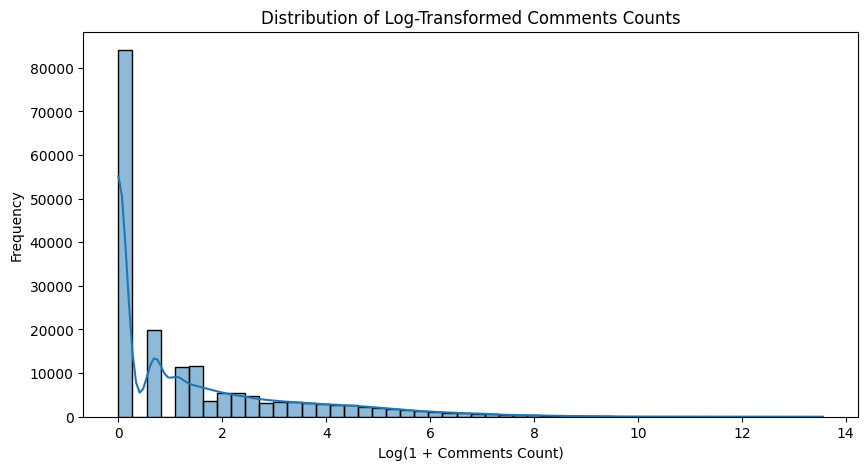

In [22]:
# 2. Distribution of Key Variables (Log-Transformed)
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['comments_count_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Comments Counts')
plt.xlabel('Log(1 + Comments Count)')
plt.ylabel('Frequency')
plt.show()

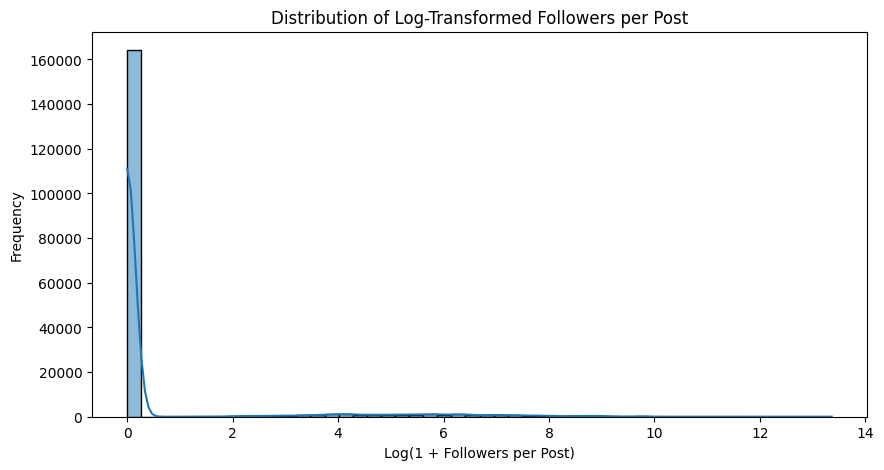

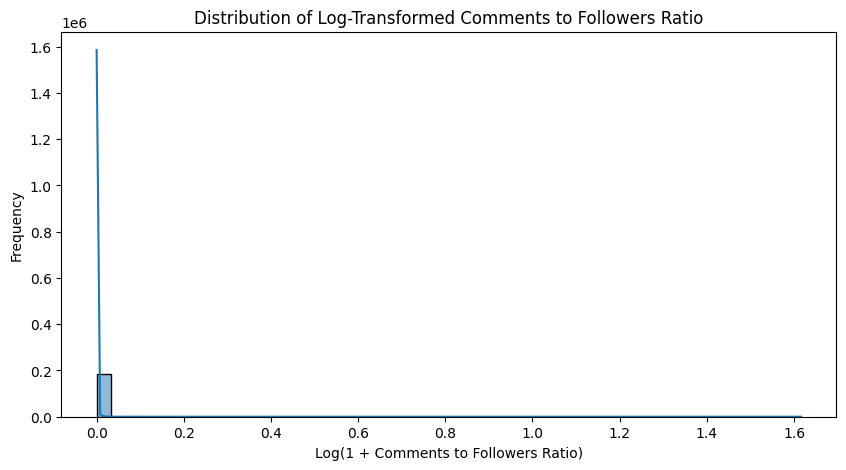

In [23]:
# 3. Distribution of Engineered Features

plt.figure(figsize=(10, 5))
sns.histplot(df_combined['followers_per_post_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Followers per Post')
plt.xlabel('Log(1 + Followers per Post)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_combined['comments_to_followers_ratio_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Comments to Followers Ratio')
plt.xlabel('Log(1 + Comments to Followers Ratio)')
plt.ylabel('Frequency')
plt.show()

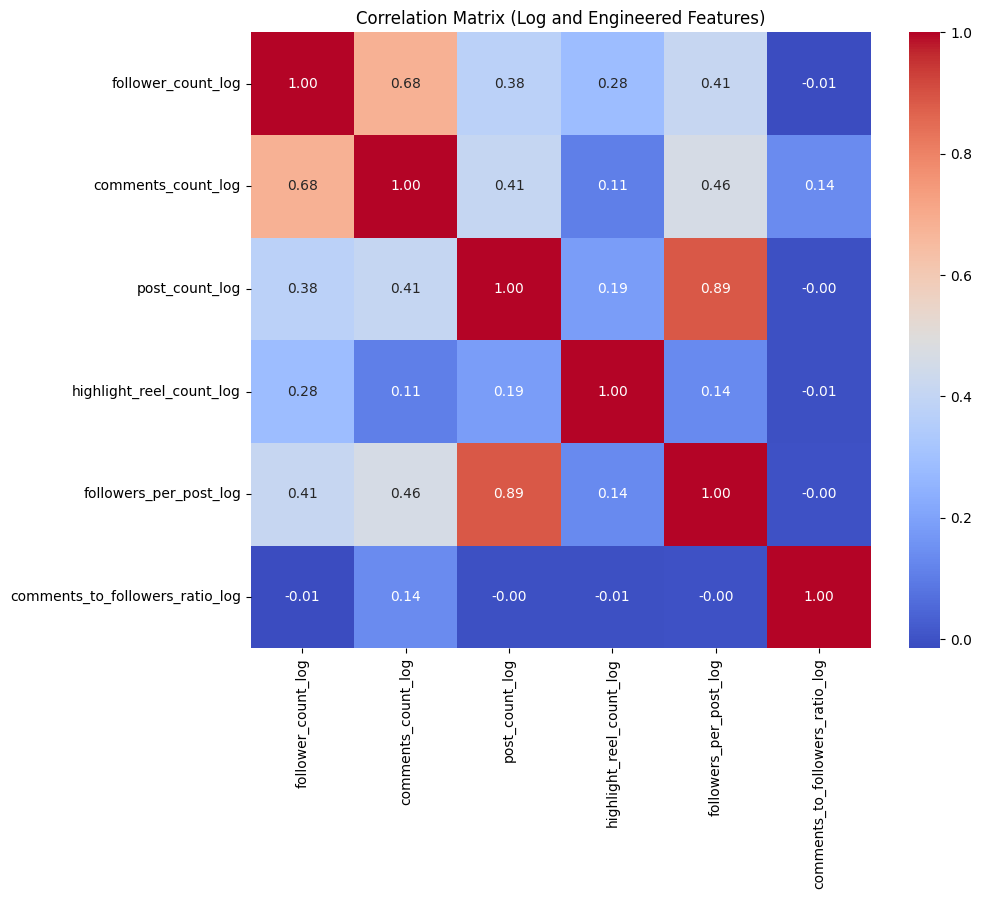

In [24]:
# 4. Correlation Analysis
numeric_features = ['follower_count_log', 'comments_count_log', 
                    'post_count_log', 'highlight_reel_count_log', 
                    'followers_per_post_log', 'comments_to_followers_ratio_log']
correlation_matrix = df_combined[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Log and Engineered Features)')
plt.show()

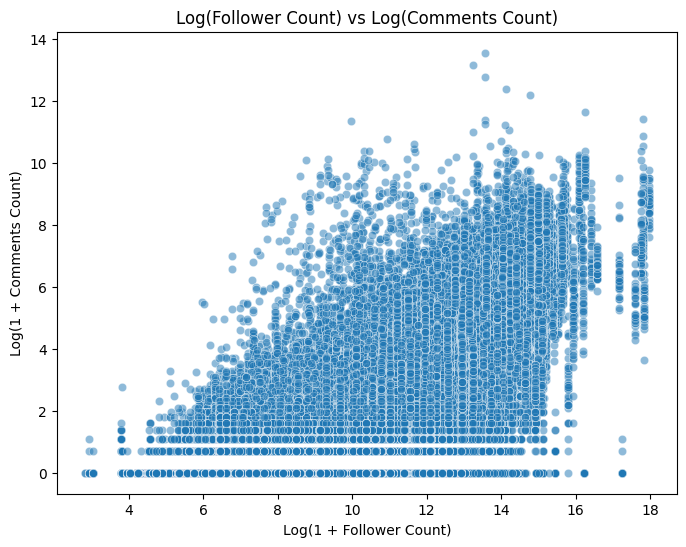

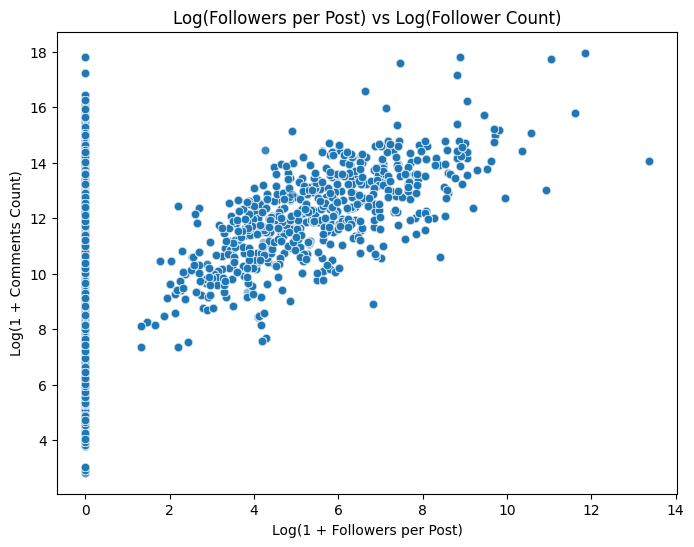

In [26]:
# 5. Scatter Plots for Key Relationships
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined['follower_count_log'], y=df_combined['comments_count_log'], alpha=0.5)
plt.title('Log(Follower Count) vs Log(Comments Count)')
plt.xlabel('Log(1 + Follower Count)')
plt.ylabel('Log(1 + Comments Count)')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined['followers_per_post_log'], y=df_combined['follower_count_log'], alpha=0.5)
plt.title('Log(Followers per Post) vs Log(Follower Count)')
plt.xlabel('Log(1 + Followers per Post)')
plt.ylabel('Log(1 + Comments Count)')
plt.show()

# 3) Random Forest Regression

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (146466, 1007), Test set shape: (36617, 1007)


In [15]:
# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [16]:
# Evaluate the model - Actual values

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Reverse log transformation for predictions and actual values
y_train_actual = np.expm1(y_train)
y_train_pred_actual = np.expm1(y_train_pred)
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(y_test_pred)

# Calculate RMSE in the original scale
train_rmse_original = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
test_rmse_original = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

# Calculate R² scores in the original scale
train_r2_original = r2_score(y_train_actual, y_train_pred_actual)
test_r2_original = r2_score(y_test_actual, y_test_pred_actual)

# Print evaluation results in the original scale
print(f"Training RMSE (Original Scale): {train_rmse_original}")
print(f"Testing RMSE (Original Scale): {test_rmse_original}")
print(f"Training R² (Original Scale): {train_r2_original}")
print(f"Testing R² (Original Scale): {test_r2_original}")


Training RMSE (Original Scale): 21877.663927029844
Testing RMSE (Original Scale): 23979.294713814652
Training R² (Original Scale): 0.8942828356660983
Testing R² (Original Scale): 0.7351916072773601


In [17]:
# Evaluate the model - log transformed values

# Calculate RMSE in log scale
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R² scores in log scale
train_r2_log = r2_score(y_train, y_train_pred)
test_r2_log = r2_score(y_test, y_test_pred)

# Print evaluation results in log scale
print(f"Training RMSE (Log Scale): {train_rmse_log}")
print(f"Testing RMSE (Log Scale): {test_rmse_log}")
print(f"Training R² (Log Scale): {train_r2_log}")
print(f"Testing R² (Log Scale): {test_r2_log}")


Training RMSE (Log Scale): 0.8045049191288624
Testing RMSE (Log Scale): 0.8848078761858468
Training R² (Log Scale): 0.8879615337844207
Testing R² (Log Scale): 0.8641430938510455


In [18]:
# Save the trained model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Model training complete and saved!")

Model training complete and saved!


# Obtaining predictions for test data

In [19]:
# function for getting profile-level information
def get_profile_info(username, df_combined):
    return df_combined[df_combined['username'] == username].head(1)

In [20]:
# function for handling test data the same way as training data
def preprocess_test_data_with_missing(data, vectorizer, scaler, feature_columns, media_type_mapping, profile_info):
    # Create a DataFrame from the single data instance
    df_test = pd.DataFrame([data])

    # Ensure no None, NaN or missing values in the 'caption' column
    if 'caption' not in df_test.columns:
        df_test['caption'] = '' 
    df_test['caption'] = df_test['caption'].fillna('').astype(str)

    # Get profile-level information 
    for field in ['post_count', 'follower_count', 'highlight_reel_count', 'followers_per_post', 'comments_to_followers_ratio']:
        df_test[field] = profile_info[field]

    # Handle heavy-tailed distributions with log transformation
    for field in ['post_count', 'follower_count', 'highlight_reel_count', 'comments_count', 'followers_per_post', 'comments_to_followers_ratio']:
        df_test[f'{field}_log'] = np.log1p(df_test.get(field, 0))

    # Textual feature extraction using TF-IDF for captions
    tfidf_features = vectorizer.transform([df_test['caption'].iloc[0]]).toarray()

    # Encode media type as a numerical feature
    if 'media_type' not in df_test.columns:
        df_test['media_type'] = "IMAGE" 
    df_test['media_type_encoded'] = df_test['media_type'].map(media_type_mapping).fillna(0)

    # Replace infinite values and handle NaNs
    df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_test.fillna(0, inplace=True)

    # Combine features: TF-IDF, comments count, media type, profile-level features, and engineered features
    features = pd.DataFrame(tfidf_features)
    features.columns = features.columns.astype(str)
    for feature in ['comments_count_log', 'media_type_encoded', 'post_count_log', 'follower_count_log', 'highlight_reel_count_log', 'followers_per_post_log', 'comments_to_followers_ratio_log']:
        features[feature] = df_test[feature]

    # Ensure the order of columns matches that of the training data feature columns
    feature_order = [col for col in feature_columns if col in features.columns]
    features = features[feature_order]

    # Standardize the features using the scaler fitted on the training data
    features_scaled = scaler.transform(features)

    return features_scaled

In [21]:
# Process JSONL file and predict
input_file = "test-regression-round2.jsonl"
output_file = "prediction-regression-round2.json"

predictions = {}

results = {}
with open(input_file, 'r') as file:
    for line in file:
        data = json.loads(line)
        profile_info = get_profile_info(data.get("username"), df_combined)
        features_scaled = preprocess_test_data_with_missing(data, tfidf_vectorizer, feature_scaler, feature_columns, media_type_mapping, profile_info)
        log_like_count = rf_regressor.predict(features_scaled)[0]
        like_count = np.expm1(log_like_count)  # Convert log count back to normal count
        results[data['id']] = int(round(like_count))  # Round and convert to integer

print(f"Predictions are completed for {input_file}")

with open(output_file, 'w') as file:
    json.dump(results, file, indent=4)

print(f"Predictions saved to {output_file}")

C:\Users\ilayd\AppData\Local\Temp\ipykernel_9948\1378977287.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.fillna(0, inplace=True)
C:\Users\ilayd\AppData\Local\Temp\ipykernel_9948\1378977287.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.fillna(0, inplace=True)
C:\Users\ilayd\AppData\Local\Temp\ipykernel_9948\1378977287.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavio

Predictions are completed for test-regression-round2.jsonl
Predictions saved to prediction-regression-round2.json
